# Import Library

In [ ]:
# Import Libraries
import os
import pandas as pd
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Visuzliation Setting
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc
from matplotlib import colors
import seaborn as sns

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
root = os.path.join(os.getcwd(), '/content/drive/MyDrive/BigContest/DATA')

# Training Data
빅콘테스트 제공 데이터 전처리

## Import Data

In [ ]:
df_raw = pd.read_excel(os.path.join(root, 'train.xlsx'))
df_train = df_raw.copy()

### Add Columns

In [ ]:
# 날짜변수 추가
df_train['year'] = df_train['REG_DATE'].dt.year
df_train['month'] = df_train['REG_DATE'].dt.month
df_train['day'] = df_train['REG_DATE'].dt.day

In [ ]:
df_train['VALUE_COUNT'] = 0;
value_dict = {}
for name, value in zip(df_train['P_NAME'].value_counts().index,df_train['P_NAME'].value_counts()):
    value_dict[name] = value

def value(col):
    return value_dict[col]

df_train['VALUE_COUNT'] = df_train['P_NAME'].apply(value)

### One hot encoding
P_IMPORT_TYPE 이라는 특수한 컬럼에 대한 전처리

In [ ]:
import_type_list = set()
for tmp in df_train.P_IMPORT_TYPE.unique():
    for a in tmp.split(','):
        import_type_list.add(a)

In [ ]:
for name in import_type_list:
    df_train[name] = 0
    df_train.loc[df_train['P_IMPORT_TYPE'].str.contains(name, regex=False), name] = 1

---

# Weather data

## Import Data

In [ ]:
df_weather_code = pd.read_excel(os.path.join(root, 'raw_weather_code.xlsx'), header=None, index_col=0)

In [ ]:
weather_list = [pd.read_csv(os.path.join(root, 'raw_weather_20151228_20161227.csv'), encoding='euc-kr') , 
                pd.read_csv(os.path.join(root, 'raw_weather_20161228_20171227.csv'), encoding='euc-kr') , 
                pd.read_csv(os.path.join(root, 'raw_weather_20171228_20181227.csv'), encoding='euc-kr') , 
                pd.read_csv(os.path.join(root, 'raw_weather_20181228_20191227.csv'), encoding='euc-kr') , 
                pd.read_csv(os.path.join(root, 'raw_weather_20191228_20201227.csv'), encoding='euc-kr') , 
                pd.read_csv(os.path.join(root, 'raw_weather_20201228_20210818.csv'), encoding='euc-kr')]


## Preprocess
- '지점'에 따른 나라명 컬럼 (country) 추가
- 각 나라, 일자 별로 평균 강수량, 풍속, 기온 계산

In [ ]:
# 지점에 따라 나라명 추가
def set_country(row):
    data = df_weather_code[df_weather_code[1] == row['지점']]
    if data.empty:
        return ""
    return data.iloc[0][2]


def preprocess_weather(df_weather):
    # 날짜 정보 정리
    df_weather['year'] = df_weather['일시'].astype('str').str[:4].astype('int')
    df_weather['month'] = df_weather['일시'].astype('str').str[5:7].astype('int')
    df_weather['day'] = df_weather['일시'].astype('str').str[8:10].astype('int')
    # 1차 평균
    df_weather['rain'] = df_weather[['지점', 'year', 'month', 'day', '강수량']].groupby(['지점', 'year', 'month', 'day']).transform('mean')
    df_weather['wind'] = df_weather[['지점', 'year', 'month', 'day', '풍속']].groupby(['지점', 'year', 'month', 'day']).transform('mean')
    df_weather['temperature'] = df_weather[['지점', 'year', 'month', 'day', '기온']].groupby(['지점', 'year', 'month', 'day']).transform('mean')
    # 컬럼/행 정리
    df_weather.drop(columns = ['지점명', '일시', '강수량', '풍속', '기온'], inplace=True)
    df_weather.drop_duplicates(inplace=True)
    # 나라명 추가
    df_weather['CTRY_1'] = ""
    for i, row in df_weather.iterrows():
        df_weather.at[i, 'CTRY_1'] = set_country(row)
    # 2차 평균
    df_weather['rain'] = df_weather[['CTRY_1', 'year', 'month', 'day', 'rain']].groupby(['CTRY_1', 'year', 'month', 'day']).transform('mean')
    df_weather['wind'] = df_weather[['CTRY_1', 'year', 'month', 'day', 'wind']].groupby(['CTRY_1', 'year', 'month', 'day']).transform('mean')
    df_weather['temperature'] = df_weather[['CTRY_1', 'year', 'month', 'day', 'temperature']].groupby(['CTRY_1', 'year', 'month', 'day']).transform('mean')
    # 컬럼/행 정리
    df_weather.drop(columns = ['지점'], inplace=True)
    df_weather.drop_duplicates(inplace=True)
    # 인덱스 정리
    df_weather.reset_index(drop=True, inplace=True)

In [ ]:
for df in weather_list:
    preprocess_weather(df)
df_weather = pd.concat(weather_list)

In [ ]:
df_weather = pd.concat(weather_list)

In [ ]:
df_weather.describe()

#### 확인필요
- outlier 찾아내기 > 값이 너무 크거나 작은 경우 제외
- 날짜별로 확인 후 비어있는 값 채워넣기 (전/다음날 이용)
    - 13947개 데이터 중 rain, wind, temperature 갯수 보면 몇개 비어있는지 확인 가능
- 합치기..
- 강수량의 경우 NaN 값이 너무 많음
    - 위 전처리들을 한 후에도 많다면 사용불가
    - 위 전처리 후에는 적다면 전날/다음날 데이터 기반으로 채워넣기 진행

## Version 2

### Import Data

In [ ]:
rwt_20152016 = pd.read_csv('/content/drive/MyDrive/빅콘/Seafood_Import_Price_Prediction/DATA/weather/raw_weather_20151228_20161227.csv',encoding='cp949') 
rwt_20162017 = pd.read_csv('/content/drive/MyDrive/빅콘/Seafood_Import_Price_Prediction/DATA/weather/raw_weather_20161228_20171227.csv',encoding='cp949') 
rwt_20172018 = pd.read_csv('/content/drive/MyDrive/빅콘/Seafood_Import_Price_Prediction/DATA/weather/raw_weather_20171228_20181227.csv',encoding='cp949') 
rwt_20182019 = pd.read_csv('/content/drive/MyDrive/빅콘/Seafood_Import_Price_Prediction/DATA/weather/raw_weather_20181228_20191227.csv',encoding='cp949') 
rwt_20192020 = pd.read_csv('/content/drive/MyDrive/빅콘/Seafood_Import_Price_Prediction/DATA/weather/raw_weather_20191228_20201227.csv',encoding='cp949') 
rwt_20202021 = pd.read_csv('/content/drive/MyDrive/빅콘/Seafood_Import_Price_Prediction/DATA/weather/raw_weather_20201228_20210818.csv',encoding='cp949') 

### Merge

In [ ]:
rwt = pd.merge(rwt_20152016,rwt_20162017,how='outer')

rwt = rwt.append(rwt_20172018)
rwt = rwt.append(rwt_20182019)
rwt = rwt.append(rwt_20192020)
rwt = rwt.append(rwt_20202021)

rwt # 국가별 강수량,풍속,기온 데이터

### 국가별로 나누기

#### 노르웨이 Weather

In [ ]:
rwt_nor = pd.DataFrame()

for i in [1373, 1007, 1233, 1114, 1098, 1002, 1317, 1152, 1028, 1008, 1415, 1001, 1212, 1492, 1384, 1241, 1403, 1065, 1196, 1271, 1026 ,1025,1465, 1238]:
    rwt_nor = rwt_nor.append(rwt[rwt['지점']==i]) # 노르웨이

rwt_nor = rwt_nor.sort_values(by=['지점','일시'])

rwt_nor['일시'] = rwt_nor['일시'].str[:10] # 시간 부분 삭제

rwt_nor['일시'] = rwt_nor['일시'].astype('datetime64')

rwt_nor = rwt_nor.query('일시.dt.dayofweek == 0') # 일시를 일주일 간격으로 변환

rwt_nor['국가'] = '노르웨이'

rwt_nor

##### Preprocessing

In [ ]:
rwt_nor['강수량'].isna().sum()

In [ ]:
sns.boxplot(x = rwt_nor['강수량'].unique())
plt.xlabel('강수량')
plt.show()
# 이상치 제거 필요

In [ ]:
rwt_nor[rwt_nor['강수량']<0]

In [ ]:
rwt_nor = rwt_nor[(rwt_nor['강수량']>=0) | (rwt_nor['강수량'].isna())] # 강수량 음수 제거

rwt_nor

In [ ]:
rwt_nor['풍속'].isna().sum()

In [ ]:
sns.boxplot(x = rwt_nor['풍속'].unique())
plt.xlabel('풍속')
plt.show()
# 이상치 제거 필요

In [ ]:
rwt_nor[rwt_nor['풍속']<0]

In [ ]:
rwt_nor = rwt_nor[(rwt_nor['풍속']>=0) | (rwt_nor['풍속'].isna())] # 강수량 음수 제거

rwt_nor

In [ ]:
rwt_nor['기온'].isna().sum()

In [ ]:
sns.boxplot(x = rwt_nor['기온'].unique())
plt.xlabel('기온')
plt.show()

# 노르웨이 최저기온은 영하 40도까지 내려간적 있으므로 오류값은 없는 것으로 판단

In [ ]:
rwt_nor = pd.DataFrame(rwt_nor.groupby(['일시'])[['강수량','풍속','기온']].mean())

rwt_nor

In [ ]:
rwt_nor.describe()

In [ ]:
rwt_nor.isna().sum()

#### 베트남 Weather

In [228]:
rwt_vit = pd.DataFrame()

for i in [48914, 48808, 48870, 48877, 48845, 48840, 48887, 48917, 48820]:
    rwt_vit = rwt_vit.append(rwt[rwt['지점']==i])

rwt_vit = rwt_vit.sort_values(by=['지점명','일시'])

rwt_vit['국가'] = '베트남'

rwt_vit['일시'] = rwt_vit['일시'].str[:10] # 시간 부분 삭제

rwt_vit['일시'] = rwt_vit['일시'].astype('datetime64')

rwt_vit = rwt_vit.query('일시.dt.dayofweek == 0') # 일시를 일주일 간격으로 변환

rwt_vit # 베트남 풍속,강수량,기온

,지점,지점명,일시,풍속,강수량,기온,국가
122236,48914,까마우,2015-12-28,5.0,NaN,29.2,베트남
122237,48914,까마우,2015-12-28,5.0,NaN,30.6,베트남
122238,48914,까마우,2015-12-28,5.0,NaN,30.3,베트남
122239,48914,까마우,2015-12-28,2.0,NaN,28.2,베트남
122240,48914,까마우,2015-12-28,0.0,NaN,26.4,베트남
...,...,...,...,...,...,...,...
27303,48917,푸꾸옥,2021-08-16,0.0,NaN,27.2,베트남
27304,48917,푸꾸옥,2021-08-16,2.0,NaN,26.8,베트남
107856,48820,하노이,2016-12-12,2.0,NaN,28.0,베트남
107857,48820,하노이,2016-12-12,3.0,NaN,25.4,베트남


##### Preprocessing

In [229]:
rwt_vit['강수량'].isna().sum()

13788

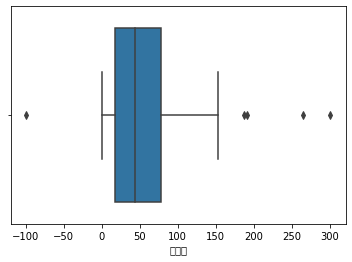

In [230]:
sns.boxplot(x = rwt_vit['강수량'].unique())
plt.xlabel('강수량')
plt.show()

# 음수인 이상치 제거 필요

In [231]:
rwt_vit[rwt_vit['강수량']<0]

,지점,지점명,일시,풍속,강수량,기온,국가
122518,48914,까마우,2016-02-01,2.0,-99.8,28.0,베트남
122625,48914,까마우,2016-02-15,1.0,-99.8,30.1,베트남
122626,48914,까마우,2016-02-15,3.0,-99.8,31.5,베트남
122627,48914,까마우,2016-02-15,3.0,-99.8,30.8,베트남
122628,48914,까마우,2016-02-15,3.0,-99.8,28.1,베트남
...,...,...,...,...,...,...,...
26181,48917,푸꾸옥,2021-02-22,5.0,-99.8,28.0,베트남
26182,48917,푸꾸옥,2021-02-22,3.0,-99.8,26.8,베트남
26183,48917,푸꾸옥,2021-02-22,0.0,-99.8,25.7,베트남
26184,48917,푸꾸옥,2021-02-22,2.0,-99.8,24.0,베트남


In [232]:
rwt_vit = rwt_vit[(rwt_vit['강수량']>=0) | (rwt_vit['강수량'].isna())] # 강수량 음수 제거

rwt_vit

,지점,지점명,일시,풍속,강수량,기온,국가
122236,48914,까마우,2015-12-28,5.0,NaN,29.2,베트남
122237,48914,까마우,2015-12-28,5.0,NaN,30.6,베트남
122238,48914,까마우,2015-12-28,5.0,NaN,30.3,베트남
122239,48914,까마우,2015-12-28,2.0,NaN,28.2,베트남
122240,48914,까마우,2015-12-28,0.0,NaN,26.4,베트남
...,...,...,...,...,...,...,...
27303,48917,푸꾸옥,2021-08-16,0.0,NaN,27.2,베트남
27304,48917,푸꾸옥,2021-08-16,2.0,NaN,26.8,베트남
107856,48820,하노이,2016-12-12,2.0,NaN,28.0,베트남
107857,48820,하노이,2016-12-12,3.0,NaN,25.4,베트남


In [233]:
rwt_vit['풍속'].isna().sum()

1

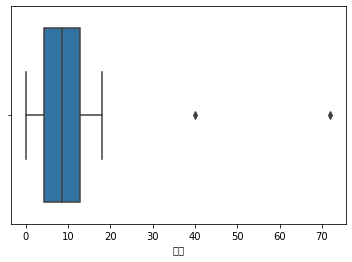

In [234]:
sns.boxplot(x = rwt_vit['풍속'].unique())
plt.xlabel('풍속')
plt.show()

In [235]:
rwt_vit['풍속'][rwt_vit['풍속']<0]

Series([], Name: 풍속, dtype: float64)

In [236]:
rwt_vit['기온'].isna().sum()

9

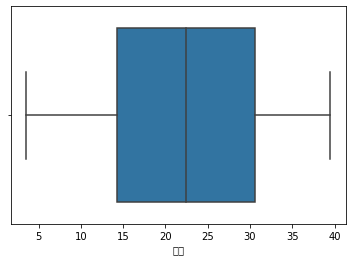

In [237]:
sns.boxplot(x = rwt_vit['기온'].unique())
plt.xlabel('기온')
plt.show()

# 이상치 없음.

In [246]:
rwt_vit2 = pd.DataFrame(rwt_vit.groupby(['일시']).mean()[['강수량','풍속','기온']])

rwt_vit2 = rwt_vit2[rwt_vit2.index<='2021-06-28']

rwt_vit2

,강수량,풍속,기온
일시,,,
2015-12-28,0.828571,2.375000,23.098214
2016-01-04,19.000000,1.666667,24.580328
2016-01-11,0.000000,2.015625,24.165625
2016-01-18,3.000000,1.822581,24.020968
2016-01-25,2.521429,3.250000,18.212500
...,...,...,...
2021-05-31,0.500000,2.156250,31.271875
2021-06-07,17.043750,2.078125,28.542188
2021-06-14,3.080000,2.234375,29.495313


In [247]:
rwt_vit2.describe()

,강수량,풍속,기온
count,273.000000,288.000000,288.000000
mean,7.190637,2.119864,26.465741
std,7.661904,0.414989,2.839870
min,0.000000,0.647059,17.800000
25%,1.000000,1.858817,24.403084
50%,4.736364,2.078125,26.842169
75%,10.554545,2.355932,28.883946
max,40.572222,3.546875,31.271875


In [248]:
rwt_vit2.isna().sum()

강수량    15
풍속      0
기온      0
dtype: int64

In [254]:
rwt_vit2[rwt_vit2['강수량'].isna()] # 해당 월 평균 강수량 데이터로 결측값 대치해보자! 

,강수량,풍속,기온,일시
일시,,,,
2016-02-08,NaN,2.355932,19.338596,2016-02-08
2016-02-29,NaN,2.946429,22.907143,2016-02-29
2017-02-06,NaN,2.343750,23.735938,2017-02-06
2017-12-18,NaN,2.921875,20.045313,2017-12-18
2018-02-05,NaN,3.125000,19.448437,2018-02-05
2018-04-02,NaN,2.156250,25.909375,2018-04-02
2018-04-09,NaN,2.269841,25.173016,2018-04-09
2019-01-28,NaN,2.031250,23.398438,2019-01-28
2019-02-04,NaN,2.609375,25.159375,2019-02-04


In [251]:
rwt_vit2['일시'] = rwt_vit2.index
rwt_vit2['일시'] = rwt_vit2['일시'].astype('string')

rain_1602 = float(rwt_vit2[rwt_vit2['일시'].str.contains('2016-02')].mean()['강수량']) # 2016년 2월 강수량 평균
rain_1702 = float(rwt_vit2[rwt_vit2['일시'].str.contains('2017-02')].mean()['강수량']) # 2017년 2월 강수량 평균
rain_1712 = float(rwt_vit2[rwt_vit2['일시'].str.contains('2017-12')].mean()['강수량']) # 2017년 12월 강수량 평균
rain_1802 = float(rwt_vit2[rwt_vit2['일시'].str.contains('2018-02')].mean()['강수량']) # 2018년 2월 강수량 평균
rain_1804 = float(rwt_vit2[rwt_vit2['일시'].str.contains('2018-04')].mean()['강수량']) # 2018년 4월 강수량 평균
rain_1901 = float(rwt_vit2[rwt_vit2['일시'].str.contains('2019-01')].mean()['강수량']) # 2019년 1월 강수량 평균
rain_1902 = float(rwt_vit2[rwt_vit2['일시'].str.contains('2019-02')].mean()['강수량']) # 2019년 2월 강수량 평균
rain_1912 = float(rwt_vit2[rwt_vit2['일시'].str.contains('2019-12')].mean()['강수량']) # 2019년 12월 강수량 평균
rain_2003 = float(rwt_vit2[rwt_vit2['일시'].str.contains('2020-03')].mean()['강수량']) # 2020년 3월 강수량 평균
rain_2004 = float(rwt_vit2[rwt_vit2['일시'].str.contains('2020-04')].mean()['강수량']) # 2020년 4월 강수량 평균
rain_2102 = float(rwt_vit2[rwt_vit2['일시'].str.contains('2021-02')].mean()['강수량']) # 2021년 2월 강수량 평균
rain_2103 = float(rwt_vit2[rwt_vit2['일시'].str.contains('2021-03')].mean()['강수량']) # 2021년 3월 강수량 평균

In [253]:
rwt_vit2[rwt_vit2['일시'].str.contains('2016-02')]['강수량'].fillna(rain_1602) # 2016년 2월 강수량 평균으로 결측값 대치
rwt_vit2[rwt_vit2['일시'].str.contains('2017-02')]['강수량'].fillna(rain_1702) # 2017년 2월 강수량 평균으로 결측값 대치
rwt_vit2[rwt_vit2['일시'].str.contains('2017-12')]['강수량'].fillna(rain_1712) # 2017년 12월 강수량 평균으로 결측값 대치
rwt_vit2[rwt_vit2['일시'].str.contains('2018-02')]['강수량'].fillna(rain_1802) # 2018년 2월 강수량 평균으로 결측값 대치
rwt_vit2[rwt_vit2['일시'].str.contains('2018-04')]['강수량'].fillna(rain_1804) # 2018년 4월 강수량 평균으로 결측값 대치
rwt_vit2[rwt_vit2['일시'].str.contains('2019-01')]['강수량'].fillna(rain_1901) # 2019년 1월 강수량 평균으로 결측값 대치
rwt_vit2[rwt_vit2['일시'].str.contains('2019-02')]['강수량'].fillna(rain_1902) # 2019년 2월 강수량 평균으로 결측값 대치
rwt_vit2[rwt_vit2['일시'].str.contains('2019-12')]['강수량'].fillna(rain_1912) # 2019년 12월 강수량 평균으로 결측값 대치
rwt_vit2[rwt_vit2['일시'].str.contains('2020-03')]['강수량'].fillna(rain_2003) # 2020년 3월 강수량 평균으로 결측값 대치
rwt_vit2[rwt_vit2['일시'].str.contains('2020-04')]['강수량'].fillna(rain_2004) # 2020년 4월 강수량 평균으로 결측값 대치
rwt_vit2[rwt_vit2['일시'].str.contains('2021-02')]['강수량'].fillna(rain_2102) # 2021년 2월 강수량 평균으로 결측값 대치
rwt_vit2[rwt_vit2['일시'].str.contains('2021-03')]['강수량'].fillna(rain_2103) # 2021년 3월 강수량 평균으로 결측값 대치

rwt_vit2.isna().sum()

강수량    15
풍속      0
기온      0
일시      0
dtype: int64

## Add to Training Data

In [ ]:
df_train = pd.merge(df_train, df_weather, how='left', on=['year', 'month', 'day', 'CTRY_1'])

In [ ]:
pd.set_option("display.max_columns", None)
df_train.sample(5)

---

# Salinity

## Import Data

In [ ]:
# df_salinity = pd.read_csv(os.path.join(root, 'raw_salinity.csv'))

## Drop Columns & Rows

In [ ]:
# df_salinity.drop(df_salinity.columns[2], inplace=True, axis=1)
# df_salinity = df_salinity[(2015 <= df_salinity['obs_year']) & (df_salinity['obs_year'] <= 2021)]

2020, 2021 데이터의 부재로 인해 보류

---

# Oil

## Import Data

In [ ]:
df_oil = pd.read_csv(os.path.join(root, 'raw_oil.csv'))
df_oil_dubai = pd.read_csv(os.path.join(root, 'raw_oil_dubai.csv'))
df_oil_brent = pd.read_csv(os.path.join(root, 'raw_oil_brent.csv'))

## Preprocess

In [ ]:
def preprocess_oil(df):
    df['year'] = df['날짜'].str[:4].astype('int')
    df['month'] = df['날짜'].str[6:8].astype('int')
    df['day'] = df['날짜'].str[10:12].astype('int')
#     df['date'] = pd.to_datetime(df['날짜'].str[:4] + df['날짜'].str[6:8] + df['날짜'].str[10:12])
#     df = df.query('date.dt.dayofweek == 0')
    df.drop(columns = ['날짜', '오픈', '고가', '저가', '거래량', '변동 %'], inplace=True, axis=1)
    df.sort_index(ascending=False)
    return df

In [ ]:
df_oil = preprocess_oil(df_oil)
df_oil_dubai = preprocess_oil(df_oil_dubai)
df_oil_brent = preprocess_oil(df_oil_brent)

## Check

In [ ]:
print("oil:", len(df_oil), "\ndubai:", len(df_oil_dubai), "\nbrent:", len(df_oil_brent))

oil과 비교하였을 때 dubai의 경우 28개, brent의 경우 3개의 데이터가 적다  
따라서 df_oil 데이터를 사용하도록 한다

## Add to Training Data

In [ ]:
df_train = pd.merge(df_train, df_oil, how='left', on=['year', 'month', 'day'])

In [ ]:
pd.set_option("display.max_columns", None)
df_train.sample(5)

---

# Korea Weather

## Import Data

In [ ]:
df_weather_kr = pd.read_csv(os.path.join(root, 'raw_weather_korea.csv'), encoding='euc-kr')

## Group
일자 별로 평균 구하기

In [ ]:
df_weather_kr['wind_kr'] = df_weather_kr[['일시', '평균 풍속(m/s)']].groupby(['일시']).transform('mean')
df_weather_kr['temperature_kr'] = df_weather_kr[['일시', '평균 기온(°C)']].groupby(['일시']).transform('mean')
df_weather_kr['water_temp_kr'] = df_weather_kr[['일시', '평균 수온(°C)']].groupby(['일시']).transform('mean')

## Preprocess Date

In [ ]:
df_weather_kr['year'] = df_weather_kr['일시'].str[:4].astype('int')
df_weather_kr['month'] = df_weather_kr['일시'].str[5:7].astype('int')
df_weather_kr['day'] = df_weather_kr['일시'].str[8:].astype('int')

## Drop Column
어차피 전부 해안가 대한민국이라 지점은 필요없다  
사용한 컬럼은 제거한다

In [ ]:
drop = ['지점', '일시', '평균 풍속(m/s)', '평균 기온(°C)', '평균 수온(°C)']

In [ ]:
df_weather_kr.drop(columns=drop, inplace=True, axis=1)

## Add to Training Data

In [ ]:
df_train = pd.merge(df_train, df_weather_kr, how='left', on=['year', 'month', 'day'])

In [ ]:
pd.set_option("display.max_columns", None)
df_train.sample(5)

---

# 소비자물가지수

## Import Data

In [ ]:
cpi_purpose = pd.read_csv("/content/drive/MyDrive/빅콘/Seafood_Import_Price_Prediction/DATA/cpi/raw_cpi_purpose.csv",encoding='cp949')  # CPI

cpi_purpose

# 소비자물가 총지수

## Drop Columns/Rows

In [ ]:
cpi_purpose.drop('시도별',axis=1,inplace=True)

cpi_purpose_copy = cpi_purpose.copy()

cpi_purpose_copy.drop('지출목적별',axis=1,inplace=True)

cpi_total = cpi_purpose_copy.iloc[0,:] # 전국 소비자물가 총지수만 추출

cpi_total = pd.DataFrame(cpi_total.values,columns=['cpi'],index=cpi_total.index)

cpi_total

## Pivoting

In [ ]:
cpi_purpose_copy = cpi_purpose.copy()

cpi_purpose_copy.drop('지출목적별',axis=1,inplace=True)

cpi_total = cpi_purpose_copy.iloc[0,:] # 전국 소비자물가 총지수만 추출

cpi_total = pd.DataFrame(cpi_total.values,columns=['cpi'],index=cpi_total.index)

cpi_total

## Pivoting

In [ ]:
cpi_purpose_copy = cpi_purpose.copy()

cpi_purpose_copy.drop('지출목적별',axis=1,inplace=True)

cpi_total = cpi_purpose_copy.iloc[0,:] # 전국 소비자물가 총지수만 추출

cpi_total = pd.DataFrame(cpi_total.values,columns=['cpi'],index=cpi_total.index)

cpi_total

# 지출목적별 소비자물가지수

In [ ]:
cpi_purpose2 = cpi_purpose.iloc[[1,11],:]

cpi_purpose2 # 전국 식료품별, 음식서비스별 cpi만 추출

In [ ]:
cpi_purpose3 = pd.DataFrame(cpi_purpose2.iloc[0,:].values,index = cpi_purpose2.columns,columns=['식료품 cpi'])

cpi_purpose3['음식 및 숙박 cpi'] = cpi_purpose2.iloc[1,:].values

cpi_purpose3.drop('지출목적별',axis=0,inplace=True) # 지출목적별 행 삭제

cpi_purpose3 # 식료품, 음식 cpi

## Preprocess Date

In [ ]:
cpi_total.reset_index(inplace=True)  # 날짜 인덱스 > 컬럼으로 변경
cpi_purpose3.reset_index(inplace=True)  # 날짜 인덱스 > 컬럼으로 변경

In [ ]:
cpi_total['year'] = cpi_total['index'].str[:4].astype('int')
cpi_total['month'] = cpi_total['index'].str[5:].astype('int')
cpi_total.drop(columns=['index'], inplace=True, axis=1)

cpi_purpose3['year'] = cpi_purpose3['index'].str[:4].astype('int')
cpi_purpose3['month'] = cpi_purpose3['index'].str[5:].astype('int')
cpi_purpose3.drop(columns=['index'], inplace=True, axis=1)

## Add to Training Data

In [ ]:
df_train = pd.merge(df_train, df_cpi1, how='left', on=['year', 'month'])
df_train = pd.merge(df_train, df_cpi2, how='left', on=['year', 'month'])

In [ ]:
pd.set_option("display.max_columns", None)
df_train.sample(5)

---

# Final

## One-hot Encoding

In [ ]:
one_hot = ['CTRY_1', 'CTRY_2', 'P_PURPOSE', 'CATEGORY_1', 'CATEGORY_2', 'P_NAME']

In [ ]:
df_train = pd.get_dummies(df_train, columns=one_hot)

## Drop Columns

In [ ]:
drop = ['REG_DATE', 'P_TYPE', 'P_IMPORT_TYPE']

In [ ]:
df_train.drop(columns = drop, inplace=True)

In [ ]:
pd.set_option("display.max_columns", None)
df_train.sample(5)

## Save Files

In [ ]:
def save_file(df, file_name):
    df.to_csv(os.path.join(root, file_name), encoding='utf-8')

In [ ]:
save_file(df_weather, 'preprocessed_weather.csv')  # 제조국 날씨
save_file(df_oil, 'preprocessed_oil.csv')  # 원유 종가
save_file(df_weather_kr, 'preprocessed_weather_korea.csv')  # 한국 날씨
save_file(df_cpi1, 'preprocessed_cpi_region.csv')  # 전체 소비자물가지수
save_file(df_cpi2, 'preprocessed_cpi_purpose.csv')  # 음식/음식서비스 소비자물가지수
save_file(df_train, 'preprocessed_train.csv')  # 최종 df